# Prelude

Connect the notebook local directory to Google drive for easy access to the data

In [1]:
from IPython.display import clear_output

In [2]:
!pip install lmfit
clear_output()

In [3]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import optimize
import scipy as scipy
from lmfit.models import ConstantModel, LorentzianModel

In [4]:
if os.path.isdir("/content/heterodyne/") and os.path.isdir("/content/split_detection/"):
    pass
else:
    !unzip /content/drive/MyDrive/allan_data/heterodyne.zip
    !unzip /content/drive/MyDrive/allan_data/split_detection.zip
clear_output()

# Processing Methods

These methods make it easy to load in .CSV files containing the spectra data.

In [5]:
def columns_to_array(df):
    """
    Create individual numpy arrays from columns of a data frame

    Args:
    df (pd.DataFrame):  The data frame to convert

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """
    result = []
    for _, col_data in df.iteritems():
        result.append(col_data.values)
    return result

def load_csv_file(fullpath, units):
    """
    Load a single csv file into memory as a pandas.DataFrame
    
    Args:
    fullpath (str):  The full path to the CSV file

    units (str):  Units to use for the spectral density.
                  Typically m^2/Hz or V^2/Hz.
    """
    return pd.read_csv(fullpath, names=["Frequency (Hz)", f"Spectral Density ({units})"])

def process_csv_file(fullpath, units):

    """
    Load a single CSV file into memeory as numpy arrays

    Args:
    fullpath (str):  The full path to the CSV file

    units (str):  Units to use for the spectral density.
                  Typically m^2/Hz or V^2/Hz.

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """

    df = load_csv_file(fullpath, units)

    return columns_to_array(df)

def match_filenames_in_dir(pattern, dirpath):

    """
    Search a directory tree for all filenames which match a specified pattern

    Args:
    pattern (str):  Expression for the filename template.

    directory(str):  Path to directory where data files are located.

    Returns:
    (list(str)):  List of all the filenames which match a specified pattern.
    """

    # List of all found files that match pattern
    result = []
    # Walk the tree
    for root, dirs, files in os.walk(dirpath):
        # Only care about files within the directory
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [6]:
def sort_key(fullpath):
    """
    Find the file number from the path to a file.
    Example:  Extract the number 109 from /.../cha_st80_109.CSV

    Args:
    fullpath (str):  The full path to the CSV file

    Returns:
    (int):  The found file number
    """

    filename = fullpath.split('/')[-1]
    filenumber = filename.split('_')[-1].strip(".CSV")
    return int(filenumber)

# Constant Patterns for Data sets

In [7]:
data_sets = {"cha":{"directory":"/content/split_detection/",
                    "pattern":"cha_st80_*.CSV",
                    "units":"m^2/Hz"},
             "chb":{"directory":"/content/split_detection/",
                    "pattern":"chb_st80_*.CSV",
                    "units":"m^2/Hz"},
             "het":{"directory":"/content/heterodyne/",
                    "pattern":"het_st80_*.CSV",
                    "units":"V^2/Hz"}}

# Visualize the Data

Superimpose the data onto a single plot (one for each data set) to get a general sense for shape and magnitude.

In [8]:
def super_plot(pattern, directory, title, units="m^2/Hz"):

    """
    Superimpose all spectra found within a directory onto a single plot

    Args:
    pattern (str):  Expression for the filename template.

    directory(str):  Path to directory where data files are located.
    """
    
    # Get a list of files
    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)
    
    # Set up a single figure 
    fig = plt.figure()
    ax = fig.add_subplot(111, title=title, xlabel="Frequency (Hz)", ylabel=f"Spectral Density ({units})")

    # Add lines to the figure
    for path in filepaths:
        df = load_csv_file(path, f"{units}")
        freq = df["Frequency (Hz)"]
        spectra = df[f"Spectral Density ({units})"]
        ax.plot(freq, spectra)
    
    plt.show()
    return 

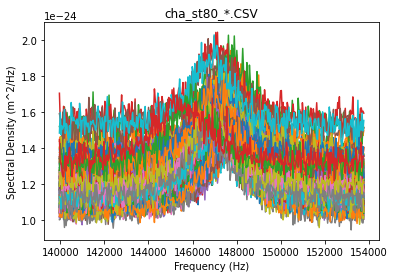

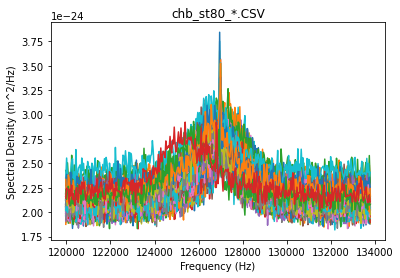

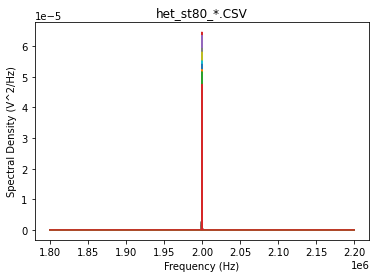

In [9]:
for data in data_sets.values():
    super_plot(data["pattern"], data["directory"], data["pattern"], data["units"])
    print("\n")

For the Heterodyne data, it would be helpful to focus the view on the central peak.

In [10]:
def center_zoom(arr, window):
    """
    Trim an array to select a centered view of size `window` 

    Args:
    arr (np.ndarray):  An array of values.

    window (int):  The size of the window to view.

    Returns:
    (np.ndarray):  The same as `arr` with window//2 elements to the left and 
                   right of the midpoint.
    """

    center = len(arr)//2
    left = center-window//2
    right = center+window//2
    selection = arr[left:right]
    return selection 

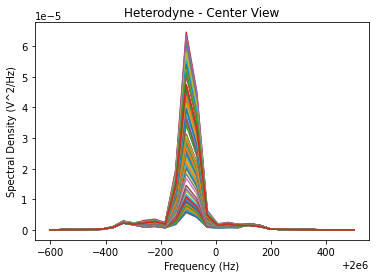

In [11]:
window_size = 30
units = "V^2/Hz" # Since looking at heterodyne data

# Get a list of files
filepaths = match_filenames_in_dir(data_sets["het"]["pattern"], data_sets["het"]["directory"])
filepaths.sort(key=sort_key)

# Set up a single figure 
fig = plt.figure()
ax = fig.add_subplot(111, title="Heterodyne - Center View", xlabel="Frequency (Hz)", ylabel=f"Spectral Density ({units})")

# Add lines to the figure
for path in filepaths:
    df = load_csv_file(path, f"{units}")
    freq = center_zoom(df["Frequency (Hz)"], window_size)
    spectrum = center_zoom(df[f"Spectral Density ({units})"], window_size)
    ax.plot(freq, spectrum)

plt.show()


# Lorentzian Fit

As seen in the previous section, sideband data (`cha_...` and `chb_...`) contain a single peak. A spectrum can be fit with the Lorentzian. 

In the following section, a fitting procedure is defined.

In [12]:
def lorentz_1d(x, amp, sigma, center):
    """
    Implement a single peak Lorentzian according to the formula at
    https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Lorentz1D.html

    Args:
    x (np.ndarray):  Values the where the Lorentzian should be computed.

    amp (float):  The amplitude of the peak.

    sigma (float):  The FWHM value of the peak. 

    center (float):  The value in the domain where the peak occurs.

    Returns:
    (np.ndarray(float)):  Values of the Lorentzian 

    """
    return (amp*sigma**2)/(sigma**2+(x-center)**2)

---

In [13]:
def plot_best_fit(freq, spectrum, best_fit_arr, title, units="m^2/Hz"):
    """
    Plot the best fit curve on top of the measured spectral density

    Args:
    freq (np.ndarray(float)):  A row array of frequency values.

    spectrum (np.ndarray(float)):  A row array of spectral density values. 
                                   Example:  Values found in chb_st80_10 as a row array

    best_fit_arr (np.ndarray(float)):  Values of the best fit curve as a row array

    title (str):  The title of the plot. Typically the file pattern or filename.

    units (str, optional):  Units to use for the spectral density.
                            Typically m^2/Hz or V^2/Hz.  
    """

    # Plot the raw data
    plt.plot(freq, spectrum, label="Spectral Density")
    # Plot the best fit curve
    plt.plot(freq, best_fit_arr, label="Best Fit")

    plt.legend()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(f"Spectra ({units})")
    plt.title(title)
    
    plt.show()
    
    return 

In [14]:
def extract_single_peak(freq, spectrum):
    # TODO:  Write a class to access attributes instead of indexing into a dict

    """
    Applies a Lorentzian fit function to the peak and extract 
    its area, mechanical frequency, and linewidth

    Args:
    freq (np.ndarray(float)):  A row array of frequency values.

    spectrum (np.ndarray(float)):  A row array of spectral density values. 
                                   Example:  Values found in chb_st80_10 as a row array

    Returns:
    (dict):
        "raw area" (float):  The area under the data curve, before a fit is applied.
        
        "fit area" (float):  The area under the best fit curve. 
        
        "mechanical frequency" (float):  The amplitude of the peak.
        
        "linewidth" (float):  The full width at half maximum (FWHM).

        "best fit object" (lmfit.model.ModelResult):  The best fit model object.
                                                      Useful for interacting with lmfit

    """
    
    # Build the model
    peak = LorentzianModel()
    background = ConstantModel()

    # Define model parameters
    pars = background.make_params(c=spectrum.min())
    pars += peak.guess(spectrum, x=freq)

    model = peak + background

    # Fit the model 
    out = model.fit(spectrum, pars, x=freq)
    
    # Extract area, mechanical frequency, and linewidth
    raw_area = np.trapz(spectrum)
    fit_area = np.trapz(out.best_fit)
    mech_freq = out.best_values["amplitude"]
    linewidth = 2*out.best_values["sigma"]


    return {"raw area":raw_area,
            "fit area":fit_area,
            "mechanical frequency":mech_freq,
            "linewidth":linewidth,
            "best fit object":out}

## Example:  Determining the Best Fit Curve and Extracting Values

The following section demonstrates finding a best fit curve for a single peak spectrum. In this case, `cha_st80_1.CSV`

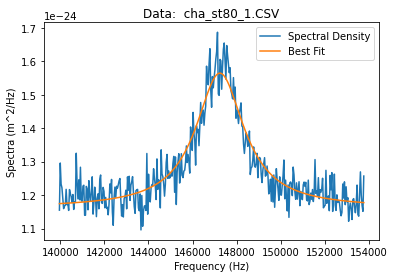

In [15]:
# Apply fitting to just 1 spectra 
cha1 = load_csv_file("/content/split_detection/cha_st80_1.CSV", "m^2/Hz")
freq = cha1["Frequency (Hz)"]
spectrum = cha1["Spectral Density (m^2/Hz)"]

cha1_best_fit = extract_single_peak(freq, spectrum)["best fit object"]
plot_best_fit(freq, spectrum, cha1_best_fit.best_fit, "Data:  cha_st80_1.CSV")

Examine values from the best fit model

In [16]:
extract_single_peak(freq, spectrum)

{'best fit object': <lmfit.model.ModelResult at 0x7f28acbb4850>,
 'fit area': 4.593357235347419e-22,
 'linewidth': 2670.2883529663086,
 'mechanical frequency': 1.691638732823799e-21,
 'raw area': 4.593058036684815e-22}

---

## Heterodyne Data - Multiple Peaks

For heterodyne data, we care about the two minor peaks that appear on either side of the main peak.

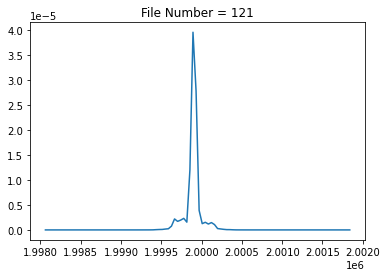

In [17]:
# Plot a heterodyne spectra to visualize the left and right peaks

window_size = 100
#random_filenumber = np.random.randint(1, 125)
random_filenumber = 121

het1 = load_csv_file(f"/content/heterodyne/het_st80_{random_filenumber}.CSV", "V^2/Hz")

het1_freq = center_zoom(het1["Frequency (Hz)"], window_size)
het1_spectra = center_zoom(het1["Spectral Density (V^2/Hz)"], window_size)

plt.plot(het1_freq, het1_spectra)
plt.title(f"File Number = {random_filenumber}")
plt.show()

~~Might have to tweak the `rel_height` parameter to get the desired minor peaks.~~

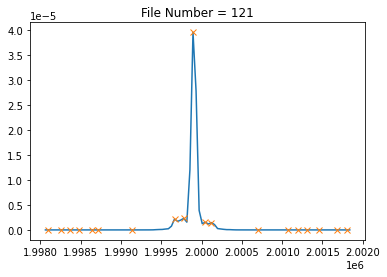

In [18]:
#peaks, _ = find_peaks(het1_spectra, height=het1_spectra.max())
peaks, _ = find_peaks(het1_spectra)
plt.plot(het1_freq, het1_spectra)
plt.plot(het1_freq.to_numpy()[peaks], het1_spectra.to_numpy()[peaks], "x")
plt.title(f"File Number = {random_filenumber}")
plt.show()

When fitting a model, we need to provide a guess for the center of the peak. If we sort the peaks by the associated height, then the major peak should be the largest value and the 2 minor peaks should be (close to) the next 2 largest values.

In [19]:
def peak_selection(heights_and_indices):
    """
    Select one peak on either side of a central peak.
    """

    heights_and_indices.sort(key=lambda pair : pair[0], reverse=True)

    center_height, center_idx = heights_and_indices[0]
    height_a, idx_a = heights_and_indices[1]

    b = None
    # The next tallest peak is left of center
    if idx_a < center_idx:
        b = next(pair for pair in heights_and_indices[2:] if pair[1] > center_idx)
    # The next tallest peak is right of center
    else:
        b = next(pair for pair in heights_and_indices[2:] if pair[1] < center_idx)
    
    return [(center_height, center_idx), (height_a, idx_a), (b)]

In [20]:
heights_and_indices = list(zip(het1_spectra.to_numpy()[peaks], peaks))
heights_and_indices.sort(key=lambda pair : pair[0], reverse=True)
heights_and_indices

[(3.963443198988304e-05, 48),
 (2.314810774274825e-06, 45),
 (2.200064469946326e-06, 42),
 (1.5295557672797429e-06, 52),
 (1.4690306208267608e-06, 54),
 (7.703160405949413e-10, 11),
 (7.470824813995792e-10, 28),
 (7.214319996037273e-10, 69),
 (5.293785985122565e-10, 85),
 (6.027986382772649e-11, 8),
 (6.010629114981116e-11, 82),
 (5.444329786651385e-11, 15),
 (5.3492898752036456e-11, 79),
 (5.265682763385146e-11, 5),
 (4.98783829162455e-11, 89),
 (4.570041503097164e-11, 98),
 (4.2613497524579945e-11, 17),
 (3.329928824321124e-11, 1),
 (2.8814559079716126e-11, 95)]

Text(0.5, 1.0, 'File Number = 121')

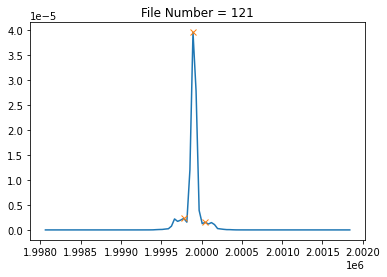

In [21]:
desired_heights = [pair[0] for pair in peak_selection(heights_and_indices)]
desired_indices = [pair[1] for pair in peak_selection(heights_and_indices)]


plt.plot(het1_freq, het1_spectra)
plt.plot(het1_freq.to_numpy()[desired_indices], desired_heights, "x")
plt.title(f"File Number = {random_filenumber}")

Now we can make the composite model

In [22]:
hfreq = het1_freq.to_numpy()
hspec = het1_spectra.to_numpy()

In [23]:
desired_indices

[48, 45, 52]

In [24]:
desired_heights

[3.963443198988304e-05, 2.314810774274825e-06, 1.5295557672797429e-06]

In [25]:
cent_model = LorentzianModel(prefix="center_")
pars = cent_model.guess(hspec, x=hfreq)



minor1 = LorentzianModel(prefix="minor1_")
pars.update(minor1.make_params())

pars["minor1_center"].set(value=hfreq[desired_indices[1]])
pars["minor1_amplitude"].set(value=desired_heights[1])



minor2 = LorentzianModel(prefix="minor2_")
pars.update(minor2.make_params())

pars["minor2_center"].set(value=hfreq[desired_indices[2]])
pars["minor2_amplitude"].set(value=desired_heights[2])

combined_model = cent_model + minor1 + minor2
out = combined_model.fit(hspec, pars, x=hfreq)

components = out.eval_components(x=hfreq)

print(out.fit_report())

[[Model]]
    ((Model(lorentzian, prefix='center_') + Model(lorentzian, prefix='minor1_')) + Model(lorentzian, prefix='minor2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3017
    # data points      = 100
    # variables        = 9
    chi-square         = 3.0319e-11
    reduced chi-square = 3.3317e-13
    Akaike info crit   = -2864.44315
    Bayesian info crit = -2840.99662
[[Variables]]
    center_amplitude:  0.00408835 +/- 7.4147e-05 (1.81%) (init = 0.09355085)
    center_center:     1999907.57 +/- 0.84843943 (0.00%) (init = 1999893)
    center_sigma:      24.2126057 +/- 1.83019715 (7.56%) (init = 629.4251)
    center_fwhm:       48.4252114 +/- 3.66039431 (7.56%) == '2.0000000*center_sigma'
    center_height:     5.3747e-05 +/- 3.7614e-06 (7.00%) == '0.3183099*center_amplitude/max(1e-15, center_sigma)'
    minor1_amplitude: -8.8224e-05 +/- 4.0651e-04 (460.77%) (init = 2.314811e-06)
    minor1_center:     2000426.94 +/- 881.411242 (0.04%) (init = 1

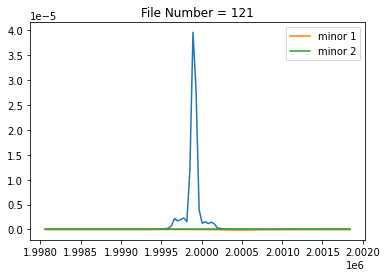

In [26]:
plt.plot(hfreq, hspec)
#plt.plot(hfreq, out.best_fit)
plt.plot(hfreq, components["minor1_"], label="minor 1")
plt.plot(hfreq, components["minor2_"], label="minor 2")

plt.title(f"File Number = {random_filenumber}")
plt.legend()

Estimate the min/max guessing range as half the distance between a minor peak and the center peak.

In [27]:
estimated_width = (hfreq[desired_indices[0]]-hfreq[desired_indices[1]])/2
alpha = 3

In [28]:
cent_model = LorentzianModel(prefix="center_")
pars = cent_model.guess(hspec, x=hfreq)



minor1 = LorentzianModel(prefix="minor1_")
pars.update(minor1.make_params())

pars["minor1_center"].set(value=hfreq[desired_indices[1]], 
                          min=hfreq[desired_indices[1]]+alpha*estimated_width, 
                          max=hfreq[desired_indices[1]]+2*alpha*estimated_width)

pars["minor1_amplitude"].set(value=desired_heights[1])



minor2 = LorentzianModel(prefix="minor2_")
pars.update(minor2.make_params())

pars["minor2_center"].set(value=hfreq[desired_indices[2]],
                          min=hfreq[desired_indices[2]]+alpha*estimated_width,
                          max=hfreq[desired_indices[2]]+2*alpha*estimated_width)
pars["minor2_amplitude"].set(value=desired_heights[2])

combined_model = cent_model + minor1 + minor2
out = combined_model.fit(hspec, pars, x=hfreq)

components = out.eval_components(x=hfreq)

print(out.fit_report())

[[Model]]
    ((Model(lorentzian, prefix='center_') + Model(lorentzian, prefix='minor1_')) + Model(lorentzian, prefix='minor2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 261
    # data points      = 100
    # variables        = 9
    chi-square         = 3.0399e-11
    reduced chi-square = 3.3406e-13
    Akaike info crit   = -2864.17660
    Bayesian info crit = -2840.73006
##  Warning: uncertainties could not be estimated:
    center_center:     at initial value
    minor1_center:     at initial value
    minor1_center:     at boundary
    minor2_center:     at initial value
    minor2_center:     at boundary
[[Variables]]
    center_amplitude:  0.00408519 (init = 0.09355085)
    center_center:     1999907.58 (init = 1999893)
    center_sigma:      24.1645130 (init = 629.4251)
    center_fwhm:       48.3290261 == '2.0000000*center_sigma'
    center_height:     5.3813e-05 == '0.3183099*center_amplitude/max(1e-15, center_sigma)'
    minor1_amplitude: 

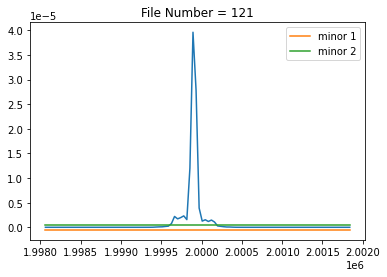

In [29]:
plt.plot(hfreq, hspec)
#plt.plot(hfreq, out.best_fit)
plt.plot(hfreq, components["minor1_"], label="minor 1")
plt.plot(hfreq, components["minor2_"], label="minor 2")
plt.title(f"File Number = {random_filenumber}")
plt.legend()

(With limited testing) Composite models are unable to fit the multiple peaks. Instead, can look into scipy's optimize method.

In [30]:
hfreq[desired_indices]

array([1999893.38846588, 1999778.94753647, 2000045.97637176])

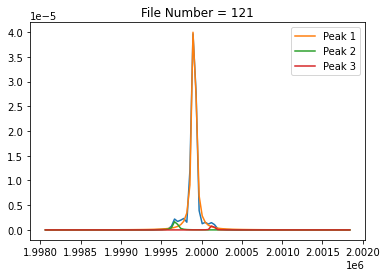

In [37]:
def _1Lorentzian(x, amp, cen, wid):
    """
    Lorentzian with 1 peak

    Args:
    x (np.ndarray(float)):  Values where the Lorentzian is evaluated.

    amp (float):  The amplitude of the peak.

    cen (float):  The value in the domain where the peak is found.

    wid (float):  Full width at half maximum (FWHM).

    Returns:
    (np.ndarray(float)):  Values for the Lorentzian computed over `x`
    """
    return amp*wid**2/((x-cen)**2+wid**2)

def _3Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2, amp3,cen3,wid3):

    """
    Lorentzian with 3 peaks
    """

    return _1Lorentzian(x, amp1, cen1, wid1) + _1Lorentzian(x, amp2, cen2, wid2) + _1Lorentzian(x, amp3, cen3, wid3)


amp1, amp2, amp3 = desired_heights
cen1, cen2, cen3 = hfreq[desired_indices]
wid1, wid2, wid3 = (10, 5, 5) # These are purely random guesses
popt_3lorentz, pcov_3lorentz = scipy.optimize.curve_fit(_3Lorentzian, hfreq, hspec, p0=[amp1, cen1, wid1, \
                                                                                    amp2, cen2, wid2, amp3, cen3, wid3])

perr_3lorentz = np.sqrt(np.diag(pcov_3lorentz))

pars_1 = popt_3lorentz[0:3]
pars_2 = popt_3lorentz[3:6]
pars_3 = popt_3lorentz[6:9]
lorentz_peak_1 = _1Lorentzian(hfreq, *pars_1)
lorentz_peak_2 = _1Lorentzian(hfreq, *pars_2)
lorentz_peak_3 = _1Lorentzian(hfreq, *pars_3)

plt.plot(hfreq, hspec)
plt.plot(hfreq, lorentz_peak_1, label="Peak 1")
plt.plot(hfreq, lorentz_peak_2, label="Peak 2")
plt.plot(hfreq, lorentz_peak_3, label="Peak 3")

plt.title(f"File Number = {random_filenumber}")
plt.legend()

# How Does Applying a Fit Affect Area Under Peak?

- Try: Simpson's rule 
    - 100x the percent error
    - Reverted back to only using the trapezoid rule

In [32]:
# Calculate the percent error between the area under
# the raw spectra data and the area under the best fit curve
pct_err = lambda a, e : 100*abs(e-a)/abs(a)

In [33]:
def single_peak_area_differences(dataset):

    """
    Compute the percent difference between the area under the 
    Lorentzian fit and the raw data using the trapezoid integration rule
    """

    directory = dataset["directory"]
    pattern = dataset["pattern"]
    units = dataset["units"]

    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)

    trapz_errors = []
    simpson_errors = []

    for path in filepaths:
        df = load_csv_file(path, units)
        freq = df["Frequency (Hz)"]
        spectrum = df[f"Spectral Density ({units})"]

        best_fit = extract_single_peak(freq, spectrum)
        trapz_errors.append(pct_err(best_fit["raw area"], best_fit["fit area"]))
    
    plt.bar(np.arange(1, 125), trapz_errors, label="Trapezoid Rule")
    plt.legend()
    plt.xlabel("File Number")
    plt.ylabel("Percent Error (%)")
    plt.title(f"Data Set:  {pattern}")
    plt.show()
    return 

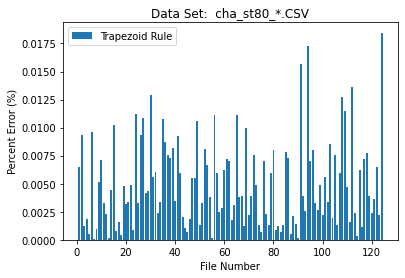

In [34]:
# Channel A
single_peak_area_differences(data_sets["cha"])

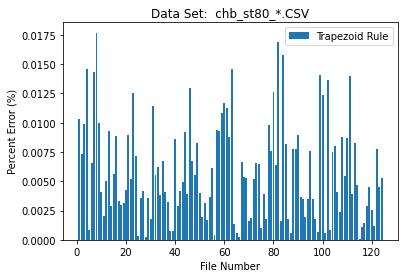

In [35]:
# Channel B
single_peak_area_differences(data_sets["chb"])

---

In [36]:
# The way to load in .dat files
areax = np.loadtxt("/content/split_detection/areay.dat")
len(areax)

124

---

# Package everything together

In [ ]:
# helper.py

def match_filenames_in_dir(pattern, directory):

    """
    Search a directory tree for all filenames which match a specified pattern

    Args:
    pattern (str):  Expression for the filename template.

    directory(str):  Path to directory where data files are located.

    Returns:
    (list(str)):  List of all the filenames which match a specified pattern.
    """

    # List of all found files that match pattern
    result = []
    # Walk the tree
    for root, dirs, files in os.walk(directory):
        # Only care about files within the directory
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result


def center_zoom(arr, window):
    """
    Trim an array to select a centered view of size `window` 

    Args:
    arr (np.ndarray):  An array of values.

    window (int):  The size of the window to view.

    Returns:
    (np.ndarray):  The same as `arr` with window//2 elements to the left and 
                   right of the midpoint.
    """

    center = len(arr)//2
    left = center-window//2
    right = center+window//2
    selection = arr[left:right]
    return selection



In [88]:
# classes.py

from dataclasses import dataclass, field

@dataclass
class SpectrumFile:
    """
    Class for working with sideband and heterodyne spectral density measurements
    """

    directory: str
    pattern: str
    units: str
    fullpath: str = field(init=False)

    def __post_init__(self):
        self.fullpath = os.path.join(self.directory, self.pattern)
        return 


    def _load_csv_file(self):
        """
        Load a single csv file into memory as a pandas.DataFrame
        
        Returns:
        (pd.DataFrame):  A pandas.DataFrame where the columns are Frequency (Hz)
                         and Spectral Density (...) with specified units.
        """

        return pd.read_csv(self.fullpath, names=["Frequency (Hz)", f"Spectral Density ({self.units})"])


    def _columns_to_array(self, df):
        """
        Create individual numpy arrays from columns of a data frame

        Args:
        df (pd.DataFrame):  The data frame to convert

        Returns:
        tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                        Length of tuple depends on number of columns.
        """
        result = []
        for _, col_data in df.iteritems():
            result.append(col_data.values)
        return result


    def spectrum_to_arrays(self):

        """
        Process a single spectrum file into memeory as numpy arrays

        Returns:
        tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                        Length of tuple depends on number of columns.
        """

        df = self._load_csv_file()

        return self._columns_to_array(df)    


    def sort_key(self):
        """
        Find the file number from the path to a file.
        Example:  Extract the number 109 from /.../cha_st80_109.CSV

        Args:
        fullpath (str):  The full path to the CSV file

        Returns:
        (int):  The found file number
        """

        filename = self.fullpath.split('/')[-1]
        filenumber = filename.split('_')[-1].strip(".CSV")
        return filenumber    

# End SpectrumFile



@dataclass
class SplitBandData(SpectrumFile):
    """
    Class for working with split band data.
    Example:  `cha_st80_1.CSV`
    """

    frequencies: np.ndarray = field(init=False)
    spectrum: np.ndarray = field(init=False)
    raw_area: float = field(init=False)
    fit_area: float = field(init=False)
    mechanical_frequency: float = field(init=False)
    linewidth: float = field(init=False)

    def __post_init__(self):
        super().__post_init__()
        self.frequencies, self.spectrum = self.spectrum_to_arrays()
        self.raw_area = np.trapz(self.spectrum)
        
        lorentzian_result = self._fit_1d_lorentzian()
        self.fit_area = np.trapz(lorentzian_result.best_fit)
        self.mechanical_frequency = lorentzian_result.best_values["amplitude"]
        self.linewidth = 2*lorentzian_result.best_values["sigma"]
        return

    def _fit_1d_lorentzian(self):
        # Define components of the model
        background = ConstantModel()
        peak = LorentzianModel()

        # Define model parameters
        pars = background.make_params(c=self.spectrum.min())
        pars += peak.guess(self.spectrum, x=self.frequencies)

        # Build the model
        model = peak + background

        # Find the best fit Lorentzian
        out = model.fit(self.spectrum, pars, x=self.frequencies)
        return out

    

# End SplitBandData



@dataclass
class HeterodyneData(SpectrumFile):
    pass
# End HeterodyneData

In [89]:
rnum = np.random.randint(1,125)

mySplitBand = SplitBandData("/content/split_detection/", f"cha_st80_{rnum}.CSV", "m^2/Hz")
myHeterodyne = HeterodyneData("/content/heterodyne/", f"het_st80_{rnum}.CSV", "V^2/Hz")

In [90]:
print(mySplitBand.frequencies)
print(mySplitBand.spectrum)
print(mySplitBand.raw_area)
print(mySplitBand.fit_area)
print(mySplitBand.mechanical_frequency)
print(mySplitBand.linewidth)

[139961.25667191 139999.40364838 140037.55062485 140075.69760132
 140113.84457779 140151.99155426 140190.13853073 140228.2855072
 140266.43248367 140304.57946014 140342.72643661 140380.87341309
 140419.02038956 140457.16736603 140495.3143425  140533.46131897
 140571.60829544 140609.75527191 140647.90224838 140686.04922485
 140724.19620132 140762.3431778  140800.49015427 140838.63713074
 140876.78410721 140914.93108368 140953.07806015 140991.22503662
 141029.37201309 141067.51898956 141105.66596603 141143.8129425
 141181.95991898 141220.10689545 141258.25387192 141296.40084839
 141334.54782486 141372.69480133 141410.8417778  141448.98875427
 141487.13573074 141525.28270721 141563.42968369 141601.57666016
 141639.72363663 141677.8706131  141716.01758957 141754.16456604
 141792.31154251 141830.45851898 141868.60549545 141906.75247192
 141944.89944839 141983.04642487 142021.19340134 142059.34037781
 142097.48735428 142135.63433075 142173.78130722 142211.92828369
 142250.07526016 142288.222